In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import tqdm
import pickle
import matplotlib.pyplot as plt
from Bio.PDB import *
from rdkit import Chem
import os
import time
import shutil
from Bio.SeqUtils import seq1
import gzip
import tarfile
import sys
import random
from rdkit.Chem import rdFreeSASA
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt

In [52]:
def good_ligand(inchi):
    try:
        m = Chem.MolFromInchi(inchi)
        count_carbons = 0
        for i in m.GetAtoms():
            if int(i.GetAtomicNum()) == 6:
                count_carbons += 1
            if count_carbons >= 7:
                break
        return count_carbons >= 7
    except:
        return False
    

# Natural amino acids
nat_aa = {'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'}
maestro_blacklist = set([i.strip() for i in pd.read_csv("/aloy/home/acomajuncosa/PocketVec_v2/kinase/PDB/LIG/preprocess/maestro_blacklist.csv")[' Residue']])
# uninteresting_ligands = pickle.load(open("/aloy/home/acomajuncosa/Apps_PocketVec/HT/PDB/uninteresting_ligands.pkl", "rb")) ## Not using it, for the moment
original_wd = os.getcwd()

In [53]:
### GET INTERESTING LIGANDS

###../data/PDB and LIGAND_PDB mapping --> https://www.ebi.ac.uk/thornton-srv/databases/pdbsum/data/lig_pairs.lst
###  2. PDB and HET_PDB mapping --> https://www.ebi.ac.uk/thornton-srv/databases/pdbsum/data/het_pairs.lst
###  3. Mapping 3-letter PDB code with inchi --> http://ligand-expo.rcsb.org/ld-download.html

pdbcode_to_inchi = pd.read_csv("../data/PDB/mapping/Components-inchi.ich.txt", sep="\t", header=None, names=['inchi', 'PDB', 'name'], usecols=[0,1])  
# From df to dict's  // PDB-LIGs
d = {}
for i,j in zip(pdbcode_to_inchi['inchi'], pdbcode_to_inchi['PDB']):
    if str(j) == 'nan': j = "NA"
    d[str(j)] = i
pdbcode_to_inchi = d; del d

interesting_ligands = set()

for lig in tqdm.tqdm(sorted(pdbcode_to_inchi)):
    inchi = pdbcode_to_inchi[lig]
    if "-" not in lig and lig not in maestro_blacklist and lig not in nat_aa and good_ligand(inchi) is True:
        interesting_ligands.add(lig)

  0%|          | 160/37360 [00:00<00:23, 1596.50it/s]RDKit ERROR: [08:32:42] ERROR: Explicit valence for atom # 19 C, 5, is greater than permitted
RDKit ERROR: [11:16:40] Explicit valence for atom # 27 Be, 4, is greater than permitted
  3%|▎         | 1043/37360 [00:00<00:25, 1409.88it/s]RDKit ERROR: [11:16:40] ERROR: Explicit valence for atom # 27 Be, 4, is greater than permitted
RDKit ERROR: [11:16:41] Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [11:16:41] ERROR: Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [11:16:41] Explicit valence for atom # 15 C, 6, is greater than permitted
  4%|▎         | 1336/37360 [00:00<00:25, 1422.51it/s]RDKit ERROR: [11:16:41] ERROR: Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [11:16:41] Explicit valence for atom # 16 N, 5, is greater than permitted
  5%|▍         | 1764/37360 [00:01<00:26, 1366.57it/s]RDKit ERROR: [11:16:41] ERROR: Explicit valence for atom # 

In [54]:
### FIND INTERESTING PDBS

pdbs_intlig = {}  # Interesting ligands
pdbs_lig = {}  # Non interesting ligands
pdbs_het = {}  # Other (e.g. non std residues)

with open("../data/PDB/mapping/lig_pairs.lst.txt", "r") as f:
    for l in f:
        pdb = l.split(":")[0].strip()
        ligs = [i.strip().strip("_") for i in l.split(":")[1].split(";")[:-1]]
        intligs = [i for i in ligs if i in interesting_ligands]
        ligs = [j for i in ligs for j in i.split("-") if j not in intligs]
        if len(ligs) > 0:
            pdbs_lig[pdb] = ligs
        if len(intligs) > 0:
            pdbs_intlig[pdb] = intligs
            
with open("../data/PDB/mapping/het_pairs.lst.txt", "r") as f:
    for l in f:
        pdb = l.split(":")[0].strip()
        hets = [i.strip() for i in l.split(":")[1].split(";")[:-1]]
        if len(hets) > 0:
            pdbs_het[pdb] = hets
            
ligands = [j for i in sorted(pdbs_intlig) for j in pdbs_intlig[i]]

In [55]:
### PREPARE THE DATAFRAME

In [56]:
# File obtained from https://ftp.ebi.ac.uk/pub/databases/pdb/derived_data/pdb_entry_type.txt
pdb_to_entrytype = pd.read_csv("../data/PDB/mapping/pdb_entry_type.txt", sep="\t", header=None, names=['PDB', 'type', 'method'])
pdb_to_entrytype = {i: j for i,j in zip(pdb_to_entrytype['PDB'], pdb_to_entrytype['type'])}

In [226]:
pdb_chain_to_uniprot = {}
df = pd.read_csv("/aloy/home/acomajuncosa/Other_Datasets/Mappings/pdb_chain_uniprot.tsv", skiprows=1, sep='\t')
for i, j, k in zip(df['PDB'], df['CHAIN'], df['SP_PRIMARY']):  ## realment volem la info de cath?
    if str(i) + "_" + str(j) not in pdb_chain_to_uniprot:
        pdb_chain_to_uniprot[str(i) + "_" + str(j)] = []
    pdb_chain_to_uniprot[str(i) + "_" + str(j)].append(k)
    
for i in pdb_chain_to_uniprot:
    pdb_chain_to_uniprot[i] = sorted(set(pdb_chain_to_uniprot[i]))

print(len(pdb_chain_to_uniprot))
for i in sorted(pdb_chain_to_uniprot):
    if len(pdb_chain_to_uniprot[i]) != 1:
        del pdb_chain_to_uniprot[i]
print(len(pdb_chain_to_uniprot))

581541
575729


In [227]:
data = []

for pdb in sorted(pdbs_intlig):
    # Interesting ligands
    for intlig in pdbs_intlig[pdb]:
        # Non interesting ligands
        lig = []
        if pdb in pdbs_lig:
            lig.extend(pdbs_lig[pdb])
        if pdb in pdbs_intlig:
            lig.extend([i for i in pdbs_intlig[pdb] if i != intlig])
        if len(lig) == 0:
            lig = np.nan
        else:
            lig = ",".join(lig)
        # Hetatms
        try:
            het = pdbs_het[pdb]
            het = [i for i in het if i not in pdbs_intlig[pdb]]
            if pdb in pdbs_lig:
                het = [i for i in het if i not in pdbs_lig[pdb]]
            if len(het) == 0:
                het = np.nan
            else:
                het = ",".join(het)
        except:
            het = np.nan
            
        if pdb in pdb_to_entrytype:
            data.append([pdb.upper(), intlig, lig, het, pdb_to_entrytype[pdb]])
        else:
            data.append([pdb.upper(), intlig, lig, het, 'Undefined'])
    
data = pd.DataFrame(data, columns=['PDB', 'INT_LIG', 'LIG', 'HET', 'type'])
data = data.loc[data['type'] == 'prot'].reset_index()
del data['index']

In [235]:
print("Number of PDBs: " + str(len(set(data['PDB']))))
print("Number of ligands: " + str(len(data['INT_LIG'])) + " (caution, each lig is considered once in each st)")
print("Number of ligands [unique]: " + str(len(set(data['INT_LIG']))))

Number of PDBs: 67582
Number of ligands: 86110 (caution, each lig is considered once in each st)
Number of ligands [unique]: 28937


In [236]:
elements = []
for i, j, k, l in zip(data['PDB'], data['INT_LIG'], data['LIG'], data['HET']):
    if type(k) == str and type(l) == str:
        elements.append([i, j, k.split(","), l.split(",")])
    if type(k) != str and type(l) != str:
        elements.append([i, j, np.nan, np.nan])
    if type(k) == str and type(l) != str:
        elements.append([i, j, k.split(","), np.nan])
    if type(k) != str and type(l) == str:
        elements.append([i, j, np.nan, l.split(",")])

elements = np.array_split(np.array(elements, dtype='object'), 3000)

In [245]:
import sys
sys.path.insert(0, '/aloy/home/acomajuncosa/programs/hpc') #CHANGE THIS PATH TO YOUR HPC PATH!
from hpc import HPC
from sbnb_config import config as cluster_config

scratch_path = "/aloy/scratch/acomajuncosa/MurD/PDB/prep1" 
script_path = "/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/scripts/prepare_sts_PDB_LIG.py"

cluster_config['queue'] = 'all.q@pac-one109'

ncpus = 2
cluster = HPC(**cluster_config)
njobs = len(elements)

cluster_params = {}
cluster_params['job_name'] = 'murd_pdb1'
cluster_params["jobdir"] = scratch_path
cluster_params["memory"] = ncpus
cluster_params['cpu'] = ncpus
cluster_params["wait"] = False
cluster_params["elements"] = elements
cluster_params["num_jobs"] = len(elements)


singularity_image = "/aloy/home/acomajuncosa/images/image_2021_09_stprep.simg"
command = "singularity exec {} python {} <TASK_ID> <FILE>".format(
singularity_image,
script_path)

cluster.submitMultiJob(command, **cluster_params)

2022-06-08 11:19:28,610 hpc.HPC      [DEBUG   ] HPC system to use: sge
2022-06-08 11:19:28,611 hpc.HPC      [DEBUG   ] initializing object sge


In [248]:
path = "/aloy/scratch/acomajuncosa/MurD/PDB/prep1"
error = set()

for file in tqdm.tqdm(sorted(os.listdir(path))):
    if '.o' in file:
        with open(os.path.join(path, file), "r") as f:
            for l in f:
                if "error" in l.lower() and "error_status = f_fix(opts, data_to_fix)" not in l:
                    print(file)
                    print(l)
                    error.add(file)
                    break

100%|██████████| 83/83 [00:02<00:00, 36.61it/s]


In [249]:
path = "/aloy/home/acomajuncosa/MurD/GitHub/summary"
results = []

for summary in tqdm.tqdm(sorted(os.listdir(path))):
    df = pd.read_csv(os.path.join(path, summary), sep='\t', names=['PDB', 'INT LIG', 'count', 'chain', 'free', 'bound', 'acc'])
    results.append(df)

results = pd.concat(results, axis=0, ignore_index=True)
# results_accessible = results.loc[(results['Accessibility'] != "-") & (results['Accessibility'].isnull() == False)]
# results_accessible = results_accessible.astype({"Accessibility": float})
results['pdb_chain'] = ["_".join([i.lower(),j]) for i,j in zip(results['PDB'], results['chain'])]
results['uniprot'] = [pdb_chain_to_uniprot[i][0] if i in pdb_chain_to_uniprot and len(pdb_chain_to_uniprot[i]) == 1 else "-" for i in results['pdb_chain']]

100%|██████████| 76/76 [00:00<00:00, 149.40it/s]


In [250]:
results

,PDB,INT LIG,count,chain,free,bound,acc,pdb_chain,uniprot
0,10GS,VWW,0,A,691.513,183.685,0.266,10gs_A,P09211
1,10GS,VWW,1,B,691.303,182.659,0.264,10gs_B,P09211
2,11BA,UPA,0,A,730.93,260.606,0.357,11ba_A,P00669
3,11BA,UPA,1,B,735.787,251.835,0.342,11ba_B,P00669
4,11BG,U2G,0,A,NaN,NaN,NaN,11bg_A,P00669
...,...,...,...,...,...,...,...,...,...
610,1AM1,ADP,0,A,541.637,107.653,0.199,1am1_A,P02829
611,1AM4,GNP,0,D,657.051,96.261,0.147,1am4_D,P60953
612,1AM4,GNP,1,E,655.13,96.503,0.147,1am4_E,P60953
613,1AM4,GNP,2,F,654.676,96.948,0.148,1am4_F,P60953


In [251]:
results.loc[results['uniprot'] == '-']

,PDB,INT LIG,count,chain,free,bound,acc,pdb_chain,uniprot
380,1A4K,FRA,0,H,638.446,227.388,0.356,1a4k_H,-
381,1A4K,FRA,1,B,646.793,236.249,0.365,1a4k_B,-
421,1A6V,NPC,0,H,525.572,181.277,0.345,1a6v_H,-
422,1A6V,NPC,1,H,527.021,129.227,0.245,1a6v_H,-
423,1A6V,NPC,2,H,539.735,152.607,0.283,1a6v_H,-
424,1A6W,NIP,0,H,NaN,NaN,NaN,1a6w_H,-


In [233]:
len(set([i + "_" + j for i, j in zip(results['uniprot'], results['INT LIG'])]))

18582

In [223]:
15/50

0.3

In [170]:
print("Number of processed PDB-LIG entities: " + str(len(results)))
print("% of entities that failed at ligand representation: " + str(round(len(results.loc[results['acc'] == 'failed2']) / len(results) * 100, 2)) + "%") 
print("% of entities that failed at SASA calculation: " + str(round(len(results.loc[results['acc'].isna() == True]) / len(results) * 100, 2)) + "%")
print("% of entities that failed at first steps: " + str(round(len(results.loc[results['acc'] == 'failed1']) / len(results) * 100, 2)) + "%") 

Number of processed PDB-LIG entities: 1221
% of entities that failed at ligand representation: 8.85%
% of entities that failed at SASA calculation: 12.61%
% of entities that failed at first steps: 0.0%


In [85]:
results = results.loc[results['count'] != '-']
results = results.loc[(results['acc'] != 'failed1') & (results['acc'] != 'failed2') & (results['acc'].isna() == False)]
results['acc'] = [float(i) for i in results['acc']]
print("Number of PDB-LIG entities without errors: " + str(len(results)))

Number of PDB-LIG entities without errors: 23448


In [88]:
results.loc[results['count'] > 1]

,PDB,INT LIG,count,free,bound,acc
17,13PK,ADP,2,576.738,81.633,0.142
18,13PK,ADP,3,579.628,77.695,0.134
44,1A0J,BEN,2,267.615,20.436,0.076
45,1A0J,BEN,3,270.897,27.537,0.102
48,1A0L,APA,2,387.065,41.925,0.108
...,...,...,...,...,...,...
29144,1JDZ,FMB,2,411.841,43.484,0.106
29147,1JE1,GMP,2,432.74,28.646,0.066
29148,1JE1,GMP,3,432.445,26.932,0.062
29149,1JE1,GMP,4,434.789,31.181,0.072


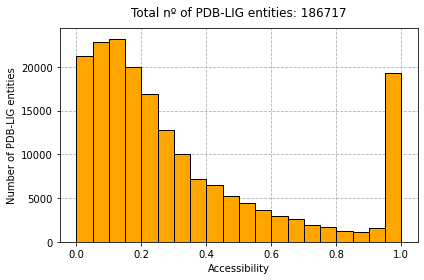

In [48]:
acc_results = results['acc']

plt.hist(acc_results, ec='black', color='orange', bins=[i for i in np.arange(0, 1.001, 0.05)], zorder=2)
plt.grid(linestyle='--')
plt.xlabel("Accessibility")
plt.ylabel("Number of PDB-LIG entities")
plt.title("Total nº of PDB-LIG entities: " + str(len(acc_results)), pad=12)
plt.tight_layout()
plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/accessibility.png", dpi=300)
plt.show()

In [49]:
results = results.loc[results['acc'] < 0.4].sort_values(by='acc').reset_index(drop=True)

In [50]:
print(len(results))
print(len(set(results['INT LIG'])))

134309
24758


In [23]:
count_ligands = Counter(results['INT LIG'])
sorted_ligands = sorted(count_ligands, key=lambda x: count_ligands[x])[::-1]
top = 20
a = np.sum([count_ligands[i] for i in sorted_ligands[:top]])
b = np.sum([count_ligands[i] for i in sorted_ligands])

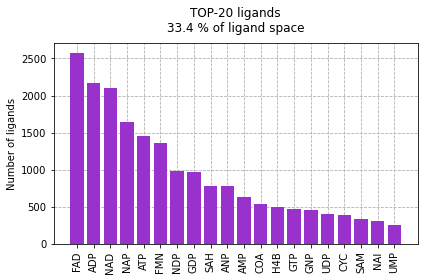

In [51]:
%matplotlib inline
plt.figure(figsize=(6, 4))
plt.grid(linestyle='--', zorder=-2)

for c, i in enumerate(sorted_ligands[:top]):
    
    plt.bar([c], count_ligands[i], color='darkorchid', zorder=2)

plt.xticks([i for i in range(top)], [i for i in sorted_ligands[:top]], rotation=90)
plt.ylabel("Number of ligands")
plt.title("TOP-" + str(top) + " ligands\n" + str(round(a/b*100, 1)) + " % of ligand space", pad=12)
plt.tight_layout()
plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/top_" + str(top) + "_ligands_bar.png", dpi=300)
plt.show()

mols = [Chem.MolFromInchi(pdbcode_to_inchi[i]) for i in sorted_ligands[:top]]
labs = [i for i in sorted_ligands[:top]]

img=Chem.Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(200,200),legends=labs)    
img.save('/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/top_' + str(top) + '_ligands.png')

503596
501214


In [102]:
# task_id = 0 

# path_to_summary = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/summary", "summary_" + str(task_id) + ".tsv")

In [156]:
pdb = "4D34"
int_lig = 'E2Z'
lig = ['SO4']
het = ['EFC']

path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/structures", pdb[1:3], pdb + "_" + int_lig)
if os.path.exists(path) is False: os.makedirs(path)

In [157]:
os.chdir(os.path.join(path))

### 1. Create directory & download pdb structure
with gzip.open('/aloy/home/acomajuncosa/programs/localpdb/mirror/pdb/' + pdb[1:3].lower() + '/pdb' + pdb.lower() + '.ent.gz', 'rb') as f_in:
    with open(os.path.join(path, pdb + ".pdb"), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [158]:
ligands_to_remove = ['W']
ligands_to_remove.append("H_" + " "*(3-len(int_lig)) + int_lig)
ligands_to_remove.append("H_" + int_lig + " "*(3-len(int_lig)))
if type(lig) == list:
    for l in lig:
        ligands_to_remove.append("H_" + " "*(3-len(l)) + l)
        ligands_to_remove.append("H_" + l + " "*(3-len(l)))
    ligands_to_remove = set(ligands_to_remove)

In [159]:
# 2. Remove water molecules and ligands // but not non std residues!
parser = PDBParser()
path_in = os.path.join(path, pdb + ".pdb")
path_out = path
structure = parser.get_structure("st", path_in)

class remove_ligs(Select):
    def accept_residue(self, residue):
        if residue.get_id()[0] not in ligands_to_remove:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save(os.path.join(path, pdb + "_st.pdb"), remove_ligs())

# 3. Remove hydrogens
command = 'python /aloy/home/acomajuncosa/programs/structureChecking/bin/check_structure -i ' + os.path.join(path_out , pdb + '_st.pdb') + ' -o ' + os.path.join(path_out , pdb + '_hydrogens.pdb') + ' --force_save --non_interactive rem_hydrogen --remove Yes'
o = os.popen(command).read()
sys.stderr.write(o + "\n\n")
sys.stderr.flush()

# 4. Select occupancies
command = 'python /aloy/home/acomajuncosa/programs/structureChecking/bin/check_structure -i ' + os.path.join(path_out , pdb + '_hydrogens.pdb') + ' -o ' + os.path.join(path_out , pdb + '_altloc.pdb') + ' --force_save --non_interactive altloc --select occupancy'
o = os.popen(command).read()
sys.stderr.write(o + "\n\n")
sys.stderr.flush()

shutil.copyfile(os.path.join(path_out , pdb + '_altloc.pdb'), os.path.join(path_out , pdb + '_' + int_lig + '.pdb'))

=                   BioBB structure checking utility v3.0.3                   =
=                 A. Hospital, P. Andrio, J.L. Gelpi 2018-20                  =

Structure /aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/structures/AJ/1AJ2_2PH/1AJ2_st.pdb loaded
 Title: 
 Experimental method: unknown
 Resolution: 0.0 A

 Num. models: 1
 Num. chains: 1 (A: Protein)
 Num. residues:  282
 Num. residues with ins. codes:  0
 Num. HETATM residues:  0
 Num. ligands or modified residues:  0
 Num. water mol.:  0
 Num. atoms:  2147

Running rem_hydrogen. Options: --remove Yes
No residues with Hydrogen atoms found
Structure not modified, saving due to --force_save option
Final Num. models: 1
Final Num. chains: 1 (A: Protein)
Final Num. residues:  282
Final Num. residues with ins. codes:  0
Final Num. HETATM residues:  0
Final Num. ligands or modified residues:  0
Final Num. water mol.:  0
Final Num. atoms:  2147
Structure saved on /aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PD

'/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/structures/AJ/1AJ2_2PH/1AJ2_2PH.pdb'

In [160]:
def get_centroid(infile, outfile):
    
    parser = PDBParser()
    structure = parser.get_structure("lig", infile)

    res = [i for i in structure.get_residues()][0]
    ligatoms = [at.coord for at in res.get_atoms()]
    x = np.mean(np.array(ligatoms)[:,0])
    y = np.mean(np.array(ligatoms)[:,1])
    z = np.mean(np.array(ligatoms)[:,2])
    center = np.array([x, y, z], dtype=np.float32)

    x, y, z = str(round(x, 3)), str(round(y, 3)), str(round(z, 3))
    ctr = " "*(8-len(x)) + x + " "*(8-len(y)) + y + " "*(8-len(z)) + z
    text = """HEADER\nHETATM    1   C  CTR A   1    """ + ctr + """  1.00  1.00           C\nEND"""

    with open(outfile, "w") as f:
        f.write(text)

In [161]:
parser = PDBParser()
structure = parser.get_structure("st", os.path.join(path, pdb + ".pdb"))
interesting_ligands = [i for i in structure.get_residues() if i.get_resname() == int_lig]


for c, interesting_ligand in enumerate(interesting_ligands):
    
    # 5. Select ligand and save it separately
    class LigSelect(Select):
        def accept_residue(self, residue):
            if residue == interesting_ligand:
                return 1
            else:
                return 0
            
    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(path, int_lig + "_" + str(c) + ".pdb"), LigSelect())
    # command = 'obabel ' + os.path.join(path, int_lig + "_" + str(c) + ".pdb") + " -O " + os.path.join(path, int_lig + "_" + str(c) + ".sd")
    # os.system(command)
    
    # Get centroid
    get_centroid(os.path.join(path, int_lig + "_" + str(c) + ".pdb"), os.path.join(path, int_lig + "_" + str(c) + "_centroid.pdb"))
    command = 'obabel ' + os.path.join(path, int_lig + "_" + str(c) + "_centroid.pdb") + " -O " + os.path.join(path, int_lig + "_" + str(c) + "_centroid.sd")
    os.system(command)

In [184]:
def SASA(prot, lig): 
    
    #compute ligand SASA
    # lig_h = Chem.rdmolops.AddHs(lig, addCoords=True, explicitOnly=True)
    lig_h = lig
    # Get Van der Waals radii (angstrom)
    ptable = Chem.GetPeriodicTable()
    radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in lig_h.GetAtoms()]
    # Compute solvent accessible surface area
    lig_sasa = rdFreeSASA.CalcSASA(lig_h, radii)

    # Join protein & ligand
    comp = Chem.CombineMols(prot, lig)
    # comp_h = Chem.AddHs(comp, addCoords=True)
    comp_h = comp
    # Get Van der Waals radii (angstrom)
    ptable = Chem.GetPeriodicTable()
    radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in comp_h.GetAtoms()]
    # Compute solvent accessible surface area
    comp_sasa = rdFreeSASA.CalcSASA(comp_h, radii)
    comp_lig = Chem.GetMolFrags(comp_h, asMols=True,  sanitizeFrags=True)
    comp_lig = [i for i in comp_lig if lig_h.GetNumHeavyAtoms() == i.GetNumHeavyAtoms()][0]
    
    lig_sasa_free = 0
    for a in lig_h.GetAtoms():
        lig_sasa_free += float(a.GetProp("SASA"))

    lig_sasa_bound = 0
    for a in comp_lig.GetAtoms():
        lig_sasa_bound += float(a.GetProp("SASA"))
        
    return round(lig_sasa_free, 3), round(lig_sasa_bound, 3)

In [185]:
# Get SASA
prot = Chem.MolFromPDBFile(os.path.join(path, pdb + "_" + int_lig + ".pdb"))
lig = Chem.MolFromPDBFile(os.path.join(path, int_lig + "_" + str(c) + ".pdb"))
# template = Chem.MolFromInchi(pdbcode_to_inchi[int_lig])
# lig = [i for i in lig][0]

if lig.GetNumHeavyAtoms() == Chem.MolFromInchi(pdbcode_to_inchi[int_lig]).GetNumHeavyAtoms():
    
    lig_sasa_free, lig_sasa_bound = SASA(prot, lig)

else:
    
    lig_sasa_free, lig_sasa_bound = np.nan, np.nan
    
acc = round(lig_sasa_bound / lig_sasa_free, 3)  

In [188]:
lig_sasa_bound

31.343

In [25]:
with open(path_to_summary, "w") as outfile:
    outfile.write("\t".join([pdb, int_lig, str(c), str(lig_sasa_free), str(lig_sasa_bound), str(acc)]) + "\n")

In [26]:
path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/structures", pdb[1:3])
os.chdir(path)   
tar = tarfile.open(pdb + "_" + int_lig + ".tar.gz", "w:gz")
tar.add(pdb + "_" + int_lig)
shutil.rmtree(pdb + "_" + int_lig)
tar.close()

In [180]:
path

'/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/structures/1A3T_THP'